<a href="https://colab.research.google.com/github/tgieruc/Noise2Noise_PyTorch/blob/main/Noise2Noise_PyTorch_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noise2Noise demo

This notebook contains a short demo of my PyTorch implementation of the Noise2Noise paper, on 32x32 images

In [ ]:
!pip install --upgrade gdown
!pip install tqdm matplotlib

In [ ]:
!git clone https://github.com/tgieruc/Noise2Noise_PyTorch
%cd Noise2Noise_PyTorch/

### Download the weights and the training and validation datasets

In [ ]:
!gdown 1bL4nZBwNs68WAuix3cq-LJZ7QrNIYWH6 # training data
!gdown 12nFadfp-uyiE8xtc3wFl9sNBZ_8EpT6m # validation data
!gdown 1JWUiX3jMr593zftQsp7YhHZSjN7xT3vG # pretrained weights

In [4]:
import torch
import numpy as np

from matplotlib import pyplot as plt
from time import time

from model import Model

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'The model will be loaded on the {"GPU" if device == "cuda" else "cpu"}.')

noisy_imgs_1, noisy_imgs_2 = torch.load('train_data.pkl')
noisy_imgs, clean_imgs = torch.load('val_data.pkl')

The model will be loaded on the GPU.


## Visualization functions

In [15]:
def display_rgb(img):
    plt.imshow(img.permute(1,2,0))
    plt.show()

def psnr_eval(model, noisy_imgs, ground_truth, nb_images=3, must_randomize=True):
    def psnr(denoised, ground_truth):
        mse = torch.mean((denoised.cpu() - ground_truth.cpu()) ** 2)
        return -10 * torch.log10(mse + 10 ** -8)

    noised = noisy_imgs.float()
    ground_truth = ground_truth.float()

    denoised = model.predict(noised) / 255

    psnr_result = psnr(denoised, (ground_truth / 255)).item()
    print(f'PSNR result: {psnr_result:.2f} dB')

    f, axarr = plt.subplots(nb_images, 3)

    if must_randomize:
        nb_index = np.random.choice(len(noised), nb_images)
    else:
        nb_index = np.arange(nb_images)
    axarr[0, 0].set_title("Noisy Images")
    axarr[0, 1].set_title("Denoised")
    axarr[0, 2].set_title("Ground Truth")

    for i, index in enumerate(nb_index):
        axarr[i, 0].imshow(noisy_imgs[index].permute(1,2,0))
        axarr[i,0].get_yaxis().set_visible(False)
        axarr[i,0].get_xaxis().set_visible(False)
        axarr[i, 1].imshow(denoised[index].cpu().detach().permute(1,2,0))
        axarr[i, 1].get_yaxis().set_visible(False)
        axarr[i, 1].get_xaxis().set_visible(False)
        axarr[i, 2].imshow(clean_imgs[index].permute(1,2,0))
        axarr[i, 2].get_yaxis().set_visible(False)
        axarr[i, 2].get_xaxis().set_visible(False)
    plt.show()

## Evaluation of pretrained model

In [7]:
model = Model()
model.load_pretrained_model("model_pytorch.pth")

PSNR result: 23.02 dB


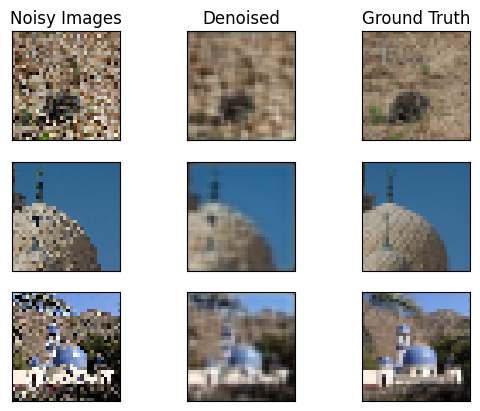

In [17]:
psnr_eval(model, noisy_imgs, clean_imgs)

## Training the model

In [18]:
model = Model()

In [19]:
model.train(noisy_imgs_1, noisy_imgs_2, num_epochs=5, batch_size=8, num_workers=1)

Epoch [4/5]: 100%|██████████| 6250/6250 [00:57<00:00, 108.41it/s, loss=0.0159]


PSNR result: 23.15 dB


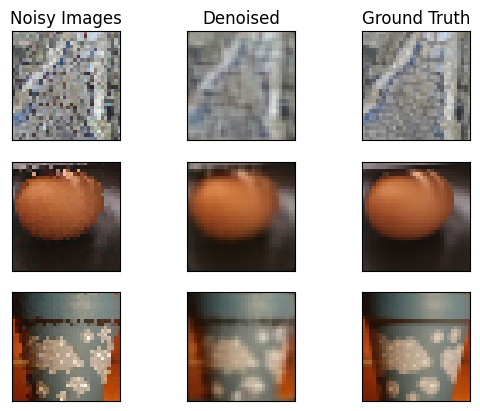

In [20]:
psnr_eval(model, noisy_imgs, clean_imgs)